In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Input, AveragePooling2D, merge, Activation, ReLU, Lambda
from keras.layers import Conv2D,SeparableConv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train,img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

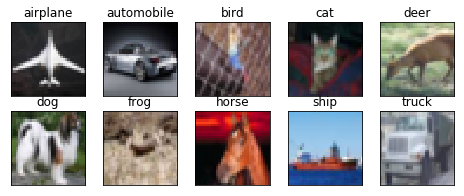

In [37]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#Convert the images in training dataset and test set into multidimentional arrays of their pixel intensity values.

train_features = train_features.reshape(train_features.shape[0], 32, 32,3)
test_features = test_features.reshape(test_features.shape[0], 32, 32,3)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#This method creates and returns a transistion block consisting of the following
# Point wise convolution
# Batch Normalization
# ReLU Activation
# Maxpooling
# Dropout
def create_trasistion_block(input, blockname):
    c1 = Conv2D(64, (1, 1), strides=(1, 1), name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = MaxPooling2D(pool_size=(2, 2))(c1)
    c1 = Dropout(0.5)(c1)
    return c1

#This method creates and returns a Normal 3x3 convolution layer followed by batch normalization and ReLU activation
def get_normconv_block(input, blockname):
    c1 = Conv2D(64, (3, 3), strides=(1, 1),padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    return c1

#This method creates and returns Spacially separable convolution layer consisting of the following
# 1X3 convolution
# 3X1 convolution
# Batch Normalization
# ReLU Activation
def get_spacialsepconv_block(input, blockname):
    c1 = Conv2D(128, (1, 3), strides=(1, 1),padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = Conv2D(128, (3, 1), strides=(1, 1),padding='same', name=(blockname+'conv_2'), use_bias=False)(c1)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    return c1

#This method creates and returns Depthwise separable convolution layer consisting of the following
# 3X3 convolution for each channel (depth_multiplier=1 ensures that the output consists of only one output channel for each input channel)
# combines all 64 '3x3' outputs in to a channel
# 1X1x64 convolutions 64 times
# Batch Normalization
# ReLU Activation
def get_depthsepconv_block(input, blockname):
    c1 = SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same',depth_multiplier=1, name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    return c1

#This method creates and returns a Group convolution layer consisting of the following
# From the input the layers will be created with 1x1, 3X3 and 5x5 convolution
# combines all the 3 layers into a single channel
# 1X1 convolution to select 128 channels
def get_groupconv3_5_block(input, blockname):
    c1 = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)

    c2 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name=(blockname+'conv_13'), use_bias=False)(input)
    c2 = BatchNormalization(name=(blockname+'norm_13'))(c1)
    c2 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)

    c3 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name=(blockname+'conv_15'), use_bias=False)(input)
    c3 = BatchNormalization(name=(blockname+'norm_15'))(c3)
    c3 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c3)

    concat_layer = Concatenate(axis=-1)([input, c1,c2,c3])
    concat_layer = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1x1'), use_bias=False)(concat_layer)
    return concat_layer

#This method creates and returns a Group convolution layer consisting of the following
# From the input the layers will be created with 1x1, 3X3 with dilation=1 and 3x3 with dilation=2 convolutions
# combines all the 3 layers into a single channel
# 1X1 convolution to select 64 channels
def get_groupconv_3_dil2_block(input, blockname):
    c1 = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)

    c2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same',dilation_rate=(1, 1), name=(blockname+'conv_13'), use_bias=False)(input)
    c2 = BatchNormalization(name=(blockname+'norm_13'))(c1)
    c2 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)

    c3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same',dilation_rate=(2, 2), name=(blockname+'conv_15'), use_bias=False)(input)
    c3 = BatchNormalization(name=(blockname+'norm_15'))(c3)
    c3 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c3)

    concat_layer = Concatenate(axis=-1)([input, c1,c2,c3])
    concat_layer = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1x1'), use_bias=False)(concat_layer)
    return concat_layer

#This method creates and returns a model consisting of different types of convolutions
# Normal 3X3 convolution
# Spacially separable 3X3 convolution
# Depthwise separable 3X3 convolution
# Group convolution with 1x1, 3X3 and 5x5 convolutions
# Group convolution with 3X3(dilation=1) and 3x3(dilation=2) convolutions
def create_model(input_shape,nb_classes=10):
    input = Input(shape=input_shape)

    norm_conv = get_normconv_block(input,'b0_')

    spacialsep_conv = get_spacialsepconv_block(norm_conv,'b1_')
    trasisionblock1 = create_trasistion_block(spacialsep_conv,'TB_1')
    depthsep_conv = get_depthsepconv_block(trasisionblock1,'b2_')
    groupconv_3x3_5x5 = get_groupconv3_5_block(depthsep_conv,'b3_')
    trasisionblock2 = create_trasistion_block(groupconv_3x3_5x5,'TB_2')
    groupconv_3x3_dil_2 = get_groupconv_3_dil2_block(trasisionblock2,'b4_')

    last_1x1_convolution = Conv2D(nb_classes, (1, 1), strides=(1, 1), name='conv1', use_bias=False)(groupconv_3x3_dil_2)
    # Once the Resolution is less than 9x9, convolution with 3x3 will not cover all the pixels.
    # So convolve with whatever is the size of the input channel i.e. 8x8 convolution
    lastconvolution = Conv2D(nb_classes, (8, 8), strides=(1, 1), name='conv2', use_bias=False)(last_1x1_convolution)

    flattenedoutput = Flatten()(lastconvolution)
    output = Activation('softmax')(flattenedoutput)
    model = Model(inputs=[input], outputs=[output])
    return model

In [0]:
model = create_model((img_rows,img_cols,img_channels), num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
b0_conv_1 (Conv2D)              (None, 32, 32, 64)   1728        input_7[0][0]                    
__________________________________________________________________________________________________
b0_norm_1 (BatchNormalization)  (None, 32, 32, 64)   256         b0_conv_1[0][0]                  
__________________________________________________________________________________________________
re_lu_59 (ReLU)                 (None, 32, 32, 64)   0           b0_norm_1[0][0]                  
__________________________________________________________________________________________________
b1_conv_1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 32s 83ms/step - loss: 1.6512 - acc: 0.4053 - val_loss: 1.5962 - val_acc: 0.4460
Epoch 2/100
390/390 [==============================] - 25s 64ms/step - loss: 1.1855 - acc: 0.5738 - val_loss: 1.2363 - val_acc: 0.5643
Epoch 3/100
390/390 [==============================] - 25s 64ms/step - loss: 0.9927 - acc: 0.6457 - val_loss: 1.0208 - val_acc: 0.6430
Epoch 4/100
390/390 [==============================] - 25s 65ms/step - loss: 0.8805 - acc: 0.6868 - val_loss: 0.8762 - val_acc: 0.6922
Epoch 5/100
390/390 [==============================] - 25s 65ms/step - loss: 0.8029 - acc: 0.7168 - val_loss: 0.9140 - val_acc: 0.6868
Epoch 6/100
390/390 [==============================] - 25s 65ms/step - loss: 0.7462 - acc: 0.7383 - val_loss: 0.7058 - val_acc: 0.7561
Epoch 7/100
390/390 [==============================] - 25s 65ms/step - loss: 0.7002 - acc: 0.7525 - val_loss: 0.9411 - val_acc: 0.6896
Epoch 8/100
390/390 [==============================] - 

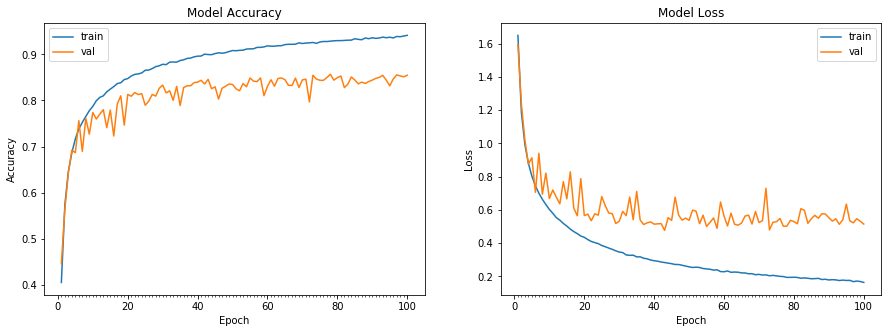

Accuracy on test data is: 85.47


In [46]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))